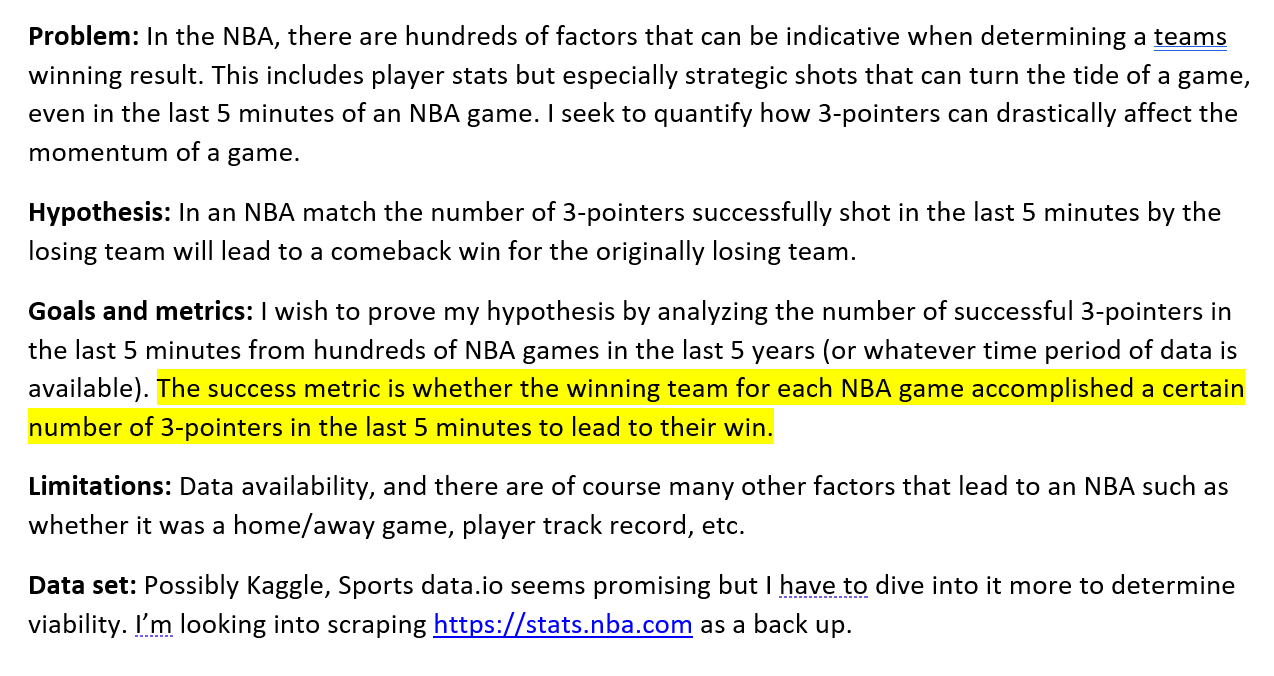

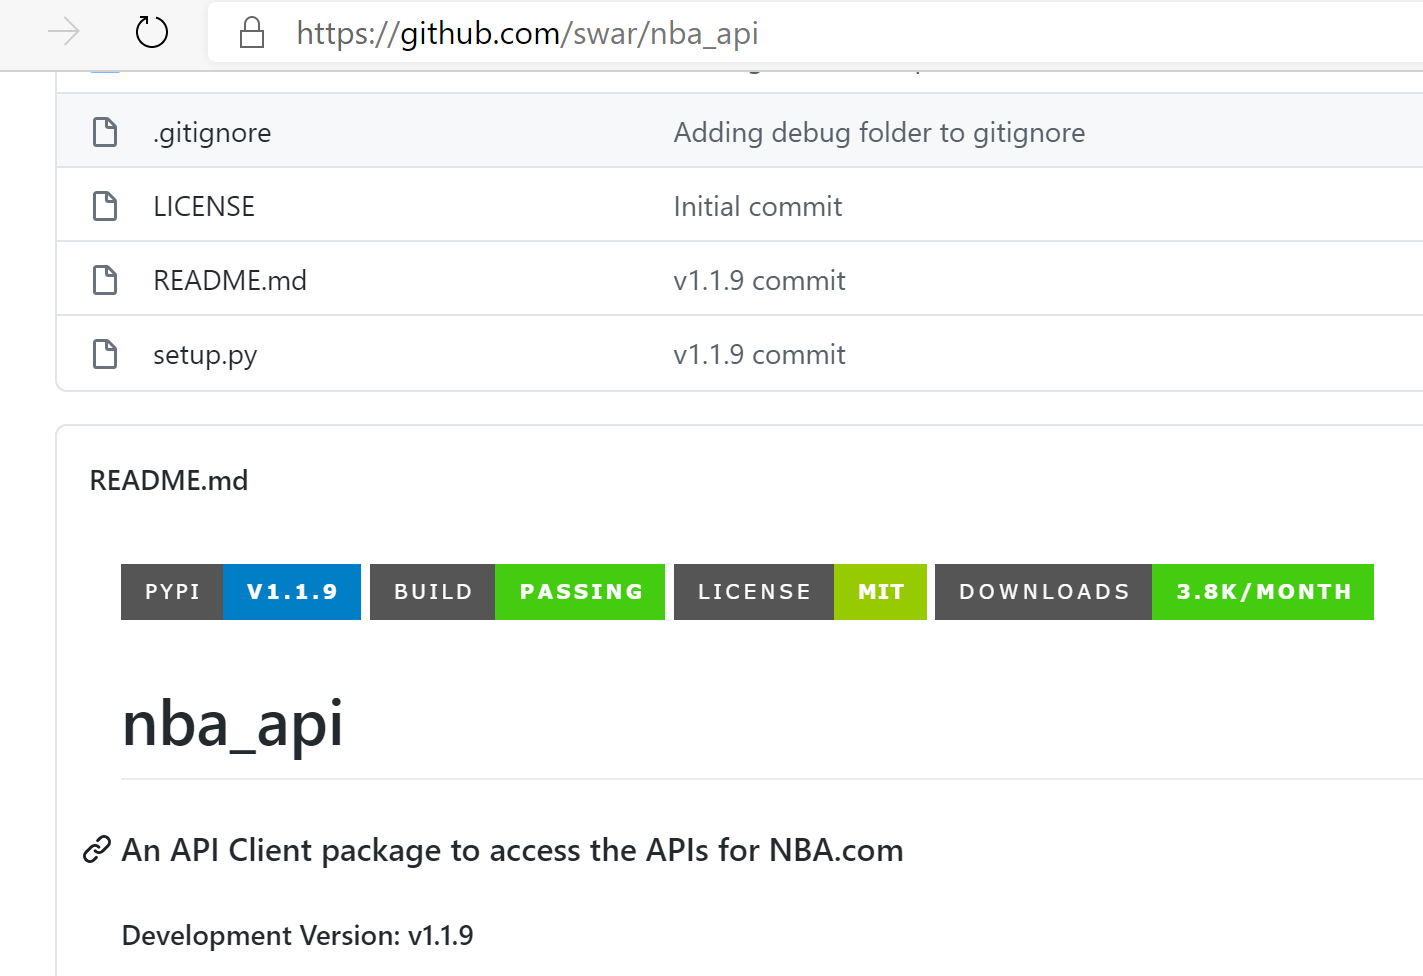

In [1]:
import pandas as pd
import nba_api
from nba_api.stats.static import teams
from nba_api.stats.endpoints import playbyplay
import re
import operator
from time import sleep
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.style.use("fivethirtyeight")

In [2]:
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.library.parameters import Season
from nba_api.stats.library.parameters import SeasonType

def Get_Games_Ids():
    sleep(3)

    #season.default is this current season 2019-2020
    gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable=Season.default,
                                                   season_type_nullable=SeasonType.regular)  

    games_dict = gamefinder.get_normalized_dict()
    
    game_id_list = []
    
    for game in games_dict['LeagueGameFinderResults']:
        
        game_id_list.append(game['GAME_ID'])
    
    #I used a set to help get rid of duplicates, as two game_id's were created for both the home and away teams
    return set(game_id_list)

In [3]:
Get_Games_Ids()

{'2021900138',
 '0021900816',
 '2021900196',
 '1021900179',
 '1021900076',
 '0021900824',
 '0021900256',
 '2021900275',
 '0021900626',
 '0021900076',
 '2021900313',
 '1221900147',
 '0021900133',
 '0021900335',
 '1221900145',
 '0021900260',
 '0021900103',
 '0021900633',
 '0921920002',
 '0021901304',
 '1221900096',
 '1021900029',
 '0021900753',
 '0021901313',
 '0021900881',
 '0021900854',
 '0021900206',
 '0021900680',
 '0021900225',
 '2021900066',
 '2021900467',
 '0021900152',
 '0021900218',
 '2021900086',
 '2021900032',
 '2021900493',
 '0021900763',
 '1021900079',
 '0021900516',
 '0021900159',
 '2021900024',
 '1621900003',
 '2021900380',
 '0021900826',
 '0021901294',
 '0021900233',
 '2021900044',
 '1521900009',
 '0021900084',
 '2021900443',
 '1621900002',
 '0021900903',
 '0021900757',
 '2021900076',
 '2021900139',
 '0021900234',
 '1521900069',
 '1521900071',
 '1021900106',
 '0021900092',
 '2021900525',
 '2021900215',
 '0021900791',
 '2021900262',
 '2021900382',
 '0021900002',
 '20219004

In [5]:
from enum import Enum
class EventMsgType(Enum):
    FIELD_GOAL_MADE = 1
    FIELD_GOAL_MISSED = 2
    FREE_THROWfree_throw_attempt = 3
    REBOUND = 4
    TURNOVER = 5
    FOUL = 6
    VIOLATION = 7
    SUBSTITUTION = 8
    TIMEOUT = 9
    JUMP_BALL = 10
    EJECTION = 11
    PERIOD_BEGIN = 12
    PERIOD_END = 13

In [11]:
def Find_Games_With_Threes(game):
    sleep(3)
    df = playbyplay.PlayByPlay(game).get_data_frames()[0]
    
    #the following expression is specific to EventMsgType 1
    p = re.compile('(\s{2}|\' )([\w+ ]*)')

    #get the PlayByPlay data from the Pacers game_id
    plays = playbyplay.PlayByPlay(game).get_normalized_dict()['PlayByPlay']

    #declare a few variables
    description = ''
    event_msg_action_types = {}

    #loop over the play by play data
    for play in plays:
        if play['EVENTMSGTYPE'] == 1:
            description = play['HOMEDESCRIPTION'] if play['HOMEDESCRIPTION'] is not None else play['VISITORDESCRIPTION']
            if description is not None:
            #do a bit of searching(regex) and a little character magic: underscores and upper case
                event_msg_action = re.sub(' ', '_', p.search(description).groups()[1].rstrip()).upper()
            #Add it to our dictionary
                event_msg_action_types[event_msg_action] = play['EVENTMSGACTIONTYPE']
            
    #sort it all
    event_msg_action_types = sorted(event_msg_action_types.items(), key=operator.itemgetter(0))
    
    ###########################
    
    #the following expression is specific to EventMsgType 1
    p2 = re.compile('(\s{2}|\' )([\w+ ]*)')

    #get the PlayByPlay data from the Pacers game_id
    plays = playbyplay.PlayByPlay(game).get_normalized_dict()['PlayByPlay']

    #declare a few variables
    description = ''
    event_msg_action_types2 = {}

    #loop over the play by play data
    #do a bit of findall(regex) and a little character magic: underscores and upper case
    #we're using a findall here as we have to deal with the extra word MISS at the beginning of the text.
    #that extra text means we'll have multiple matches for our regex.
    for play in plays:
        if play['EVENTMSGTYPE'] == 2:
            match = list()
            if play['HOMEDESCRIPTION'] is not None: 
                match = p2.findall(play['HOMEDESCRIPTION'])
        
            if not match:
                match = p2.findall(play['VISITORDESCRIPTION'])

            event_msg_action = re.sub(' ', '_', match[0][1]).upper()
            event_msg_action_types2[event_msg_action] = play['EVENTMSGACTIONTYPE']
        
    # if play['EVENTMSGACTIONTYPE']
        
    event_msg_action_types2 = sorted(event_msg_action_types2.items(), key=operator.itemgetter(0))

    
    three_pt_cond = (df['HOMEDESCRIPTION'].str.contains("3PT") | df['NEUTRALDESCRIPTION'].str.contains("3PT")|df['VISITORDESCRIPTION'].str.contains("3PT"))
    
    made_shot_cond = (df['EVENTMSGTYPE'] == 1)
    
    fourth_qtr_cond =  (df['PERIOD'] == 4)
    
    type_shot_cond = (df['EVENTMSGACTIONTYPE'] == 1) | (df['EVENTMSGACTIONTYPE'] == 79) | (df['EVENTMSGACTIONTYPE'] == 80)
                         
    num_of_threes = pd.DataFrame(plays).loc[
    (type_shot_cond) 
    & 
    (fourth_qtr_cond) 
    &  
    (made_shot_cond) 
    & (three_pt_cond) 
    & (df['PCTIMESTRING'].apply(lambda x : x[:-3] ).astype(int) <= 5), :].shape[0]
    
    df = df[df['GAME_ID'] == game].copy()
    
    df['threes_under_five'] = num_of_threes
    
    return df
    

In [22]:
#creating a dictionary to hold each game
game_df_dict = {}

for idx,game in enumerate(Get_Games_Ids()):
    if idx > 90:
        break
    else:    
        game_df_dict[game] = Find_Games_With_Threes(game)
    

In [23]:
game_df_dict.keys()

dict_keys(['2021900138', '0021900816', '2021900196', '1021900179', '1021900076', '0021900824', '0021900256', '2021900275', '0021900626', '0021900076', '2021900313', '1221900147', '0021900133', '0021900335', '1221900145', '0021900260', '0021900103', '0021900633', '0921920002', '0021901304', '1221900096', '1021900029', '0021900753', '0021901313', '0021900881', '0021900854', '0021900206', '0021900680', '0021900225', '2021900066', '2021900467', '0021900152', '0021900218', '2021900086', '2021900032', '2021900493', '0021900763', '1021900079', '0021900516', '0021900159', '2021900024', '1621900003', '2021900380', '0021900826', '0021901294', '0021900233', '2021900044', '1521900009', '0021900084', '2021900443', '1621900002', '0021900903', '0021900757', '2021900076', '2021900139', '0021900234', '1521900069', '1521900071', '1021900106', '0021900092', '2021900525', '2021900215', '0021900791', '2021900262', '2021900382', '0021900002', '2021900495', '0021900584', '1021900148', '0021900427', '15219000

In [14]:
game_df_dict['2021900138']

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN,threes_under_five
0,2021900138,2,12,0,1,8:02 PM,12:00,None,None,None,None,None,4
1,2021900138,4,10,0,1,8:03 PM,12:00,Jump Ball Brown vs. Metu: Tip to Farrell,None,None,None,None,4
2,2021900138,7,2,6,1,8:03 PM,11:47,None,None,MISS Samanic 2' Driving Layup,None,None,4
3,2021900138,8,4,0,1,8:03 PM,11:45,None,None,Metu REBOUND (Off:1 Def:0),None,None,4
4,2021900138,9,2,72,1,8:03 PM,11:43,None,None,MISS Metu 1' Putback Layup,None,None,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,2021900138,719,6,1,4,10:05 PM,0:02,None,None,Samanic P.FOUL (P5.PN),None,None,4
491,2021900138,721,3,11,4,10:06 PM,0:02,MISS Mathias Free Throw 1 of 2,None,None,None,None,4
492,2021900138,722,4,1,4,10:06 PM,0:02,LEGENDS Rebound,None,None,None,None,4
493,2021900138,723,3,12,4,10:06 PM,0:02,Mathias Free Throw 2 of 2 (15 PTS),None,None,137 - 126,-11,4


In [162]:
#final dataframe for manipulation, with threes_under_five column added
final_df = pd.DataFrame()

for key in game_df_dict:
    final_df = final_df.append(game_df_dict[key], ignore_index=True)

In [164]:
final_df

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN,threes_under_five
0,2021900138,2,12,0,1,8:02 PM,12:00,None,None,None,None,None,4
1,2021900138,4,10,0,1,8:03 PM,12:00,Jump Ball Brown vs. Metu: Tip to Farrell,None,None,None,None,4
2,2021900138,7,2,6,1,8:03 PM,11:47,None,None,MISS Samanic 2' Driving Layup,None,None,4
3,2021900138,8,4,0,1,8:03 PM,11:45,None,None,Metu REBOUND (Off:1 Def:0),None,None,4
4,2021900138,9,2,72,1,8:03 PM,11:43,None,None,MISS Metu 1' Putback Layup,None,None,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39031,0021900602,615,1,1,4,12:46 AM,1:03,None,None,Barea 26' 3PT Jump Shot (8 PTS),121 - 92,-29,6
39032,0021900602,616,1,108,4,12:46 AM,0:52,Paschall 1' Cutting Dunk Shot (16 PTS) (Poole 5 AST),None,None,121 - 94,-27,6
39033,0021900602,618,1,1,4,12:47 AM,0:42,None,None,Barea 28' 3PT Jump Shot (11 PTS),124 - 94,-30,6
39034,0021900602,619,1,1,4,12:47 AM,0:23,Burks 26' 3PT Jump Shot (10 PTS) (Smailagic 3 AST),None,None,124 - 97,-27,6


## Determining is_comeback value

In [171]:
# the values "TIE" and "None" are in the column SCOREMARGIN, so force them to be 0
final_df.SCOREMARGIN = final_df.SCOREMARGIN.replace({np.nan: 0, 'TIE': 0})
# force all values in SCOREMARGIN to be integer type, because right now most of them are strings
final_df = final_df.astype({'SCOREMARGIN': np.int64})

In [172]:
data = []
for game in final_df['GAME_ID'].unique():
    
    game_df = final_df[final_df['GAME_ID'] == game]
    
    before_last_five = game_df[game_df['PCTIMESTRING'].apply(lambda x : x[:-3] ).astype(int) >= 5]
    
    for idx in range(before_last_five.shape[0] - 1, -1 , -1):
        if before_last_five.iloc[idx]['SCORE'] != None:
            initial_score_marg = int(before_last_five.iloc[idx]['SCOREMARGIN'])
            break
    
    
    num_of_threes = game_df.tail(1)['threes_under_five'].values[0]
    
    if (game_df.tail(1)['SCOREMARGIN'].astype(int) > 0).values[0] and initial_score_marg < 0 :
        is_comeback = True
    else :
        is_comeback = False
    
    data.append([game, num_of_threes, is_comeback])
    

# Creation of a simplified final dataframe

In [229]:
simplified_final_df = pd.DataFrame(data, columns = ['GAME_ID', 'threes_under_five', 'is comeback?']) 


In [233]:
simplified_final_df.head(5)

,GAME_ID,threes_under_five,is comeback?
0,2021900138,4,False
1,0021900816,4,False
2,2021900196,1,False
3,1021900179,2,False
4,1021900076,1,False


In [194]:
df2 = final_df.EVENTMSGACTIONTYPE.value_counts()

In [211]:
definition_dict = { 1   : '3PT_JUMP_SHOT',
79  : '3PT_PULLUP_JUMP_SHOT',
2   : '3PT_RUNNING_JUMP_SHOT',
103 : '3PT_RUNNING_PULL',
43  : 'ALLEY_OOP_LAYUP',
108 : 'CUTTING_DUNK_SHOT',
98  : 'CUTTING_LAYUP_SHOT',
9   : 'DRIVING_DUNK',
102 : 'DRIVING_FLOATING_BANK_JUMP_SHOT',
57  : 'DRIVING_HOOK_SHOT',
63  : '3PT_FADEAWAY_JUMPER',
6   : 'DRIVING_LAYUP',
7   : 'DRIVING_REVERSE_LAYUP',
63  : 'FADEAWAY_JUMPER',
78  : 'FLOATING_JUMP_SHOT',
3   : 'HOOK_SHOT',
1   : 'JUMP_SHOT',
5   : 'LAYUP',
79  : 'PULLUP_JUMP_SHOT',
50  : 'RUNNING_DUNK',
41  : 'RUNNING_LAYUP',
80  : 'STEP_BACK_JUMP_SHOT',
107 : 'TIP_DUNK_SHOT',
97  : 'TIP_LAYUP_SHOT',
105 : 'TURNAROUND_FADEAWAY_BANK_JUMP_SHOT',
58  : 'TURNAROUND_HOOK_SHOT',
47  : 'TURNAROUND_JUMP_SHOT'}

In [212]:
def event_num_lookup(evt_num):
    if evt_num in definition_dict:
        return definition_dict[evt_num]
    else:
        return None

In [213]:
final_df['event_name'] = final_df.EVENTMSGACTIONTYPE.apply(event_num_lookup)  

# Charts and Analysis

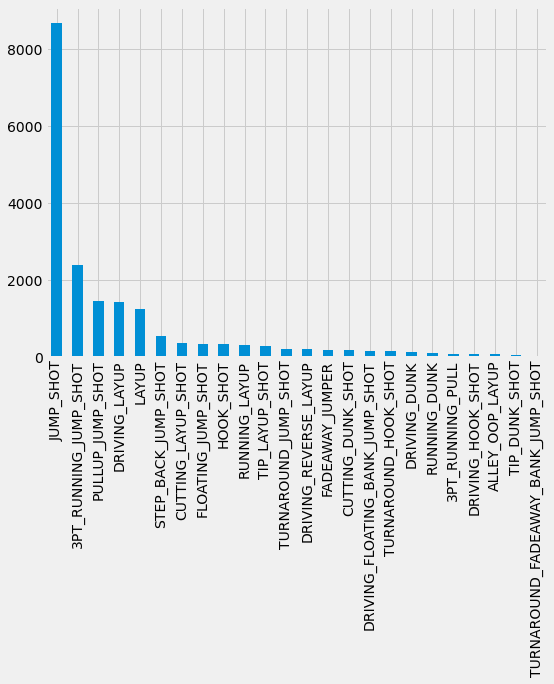

In [216]:
final_df['event_name'].value_counts().plot(kind='bar');

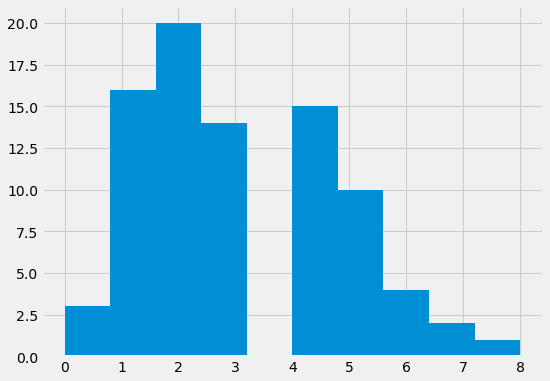

In [236]:
simplified_final_df['threes_under_five'].hist();

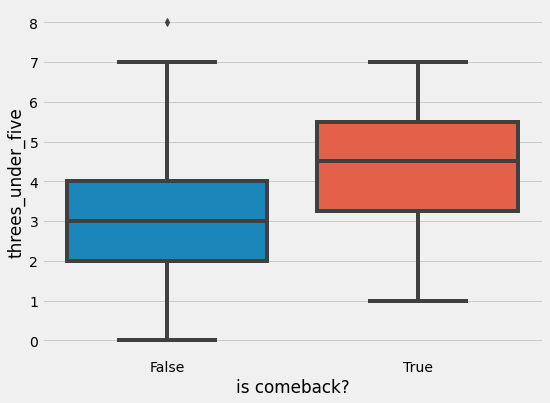

In [179]:
sns.boxplot(x=actual_final_df['is comeback?'],y=actual_final_df['threes_under_five']);

In [228]:
actual_final_df[actual_final_df['is comeback?'] == False]['threes_under_five'].median()

3.0

In [227]:
actual_final_df[actual_final_df['is comeback?'] == True]['threes_under_five'].median()

4.5

# For future iterations :

Work on getting more data together for better analysis: Yearly, Specific Teams etc.

Analize different factors that come into play: who may be taking those final shots, determing frequency of comebacks per player etc.